<a href="https://colab.research.google.com/github/Vigneshthanga/MachineLearning-CMPE257/blob/master/GMM_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Comparission of K-Means and GMM Clustering on Air Quality Data collected from OpenAQ

In [0]:
!git clone https://github.com/Vigneshthanga/MachineLearning-CMPE257

fatal: destination path 'MachineLearning-CMPE257' already exists and is not an empty directory.


##1. Loading the OpenAQ data from google drive. Google drive link: https://drive.google.com/open?id=1PwsdbPXpxXvRi0NOJakvR06cRS2hxF4D

In [0]:
import pandas as pd
df = pd.read_csv("MachineLearning-CMPE257/AQ_Boston_Cam-Quincy.csv")
df = df.apply(lambda s:s.str.replace('\'', "").str.replace('[', ""))
df.columns = df.columns.str.strip().str.replace('[', '').str.replace(']', '').str.replace('\'','')
df.drop(df.columns[[10,11,12]], axis=1, inplace=True)
df.head(5)

,location,city,country,utc,local,parameter,value,unit,latitude,longitude
0,Portsmouth,Boston-Cambridge-Quincy,US,2020-02-09T18:00:00.000Z,2020-02-09T13:00:00-05:00,o3,0.035,ppm,43.075371,-70.748017
1,Odiorne State Park,Boston-Cambridge-Quincy,US,2020-02-09T18:00:00.000Z,2020-02-09T13:00:00-05:00,o3,0.038,ppm,43.045269,-70.713958
2,Portsmouth,Boston-Cambridge-Quincy,US,2020-02-09T18:00:00.000Z,2020-02-09T13:00:00-05:00,pm10,10,µg/m³,43.075371,-70.748017
3,Portsmouth,Boston-Cambridge-Quincy,US,2020-02-09T18:00:00.000Z,2020-02-09T13:00:00-05:00,pm25,4.8,µg/m³,43.075371,-70.748017
4,LYNN,Boston-Cambridge-Quincy,US,2020-02-09T17:00:00.000Z,2020-02-09T12:00:00-05:00,no2,0.008,ppm,42.474701,-70.971901


##2. Converting 'local' columns to datetime format and saving it in 'local_time' column

In [0]:
df['local_time'] = pd.to_datetime(df.local)
df.dtypes
df.head()

,location,city,country,utc,local,parameter,value,unit,latitude,longitude,local_time
0,Portsmouth,Boston-Cambridge-Quincy,US,2020-02-09T18:00:00.000Z,2020-02-09T13:00:00-05:00,o3,0.035,ppm,43.075371,-70.748017,2020-02-09 13:00:00-05:00
1,Odiorne State Park,Boston-Cambridge-Quincy,US,2020-02-09T18:00:00.000Z,2020-02-09T13:00:00-05:00,o3,0.038,ppm,43.045269,-70.713958,2020-02-09 13:00:00-05:00
2,Portsmouth,Boston-Cambridge-Quincy,US,2020-02-09T18:00:00.000Z,2020-02-09T13:00:00-05:00,pm10,10,µg/m³,43.075371,-70.748017,2020-02-09 13:00:00-05:00
3,Portsmouth,Boston-Cambridge-Quincy,US,2020-02-09T18:00:00.000Z,2020-02-09T13:00:00-05:00,pm25,4.8,µg/m³,43.075371,-70.748017,2020-02-09 13:00:00-05:00
4,LYNN,Boston-Cambridge-Quincy,US,2020-02-09T17:00:00.000Z,2020-02-09T12:00:00-05:00,no2,0.008,ppm,42.474701,-70.971901,2020-02-09 12:00:00-05:00


In [0]:
import datetime
df['date'] = pd.DatetimeIndex(df['local_time']).date
df['date'] = df['date'].apply(lambda x: x.strftime('%Y-%m-%d'))
x = datetime.datetime(2020,2,9)
is_feb9 = df['date'] == x
is_portsmouth = df['location'] == "Portsmouth"
df.dtypes

location                                      object
city                                          object
country                                       object
utc                                           object
local                                         object
parameter                                     object
value                                         object
unit                                          object
latitude                                      object
longitude                                     object
local_time    datetime64[ns, pytz.FixedOffset(-300)]
date                                          object
dtype: object

##2. Change the dtypes of attributes from object to float and encode the location and timestamp.

In [0]:
import numpy as np
df['location'] = df['location'].astype('category')
df['location'] = df['location'].cat.codes

df['local'] = df['local'].astype('category')
df['local'] = df['local'].cat.codes

table = pd.pivot_table(df, values='value', index=['location', 'local', 'date'], columns=['parameter'], aggfunc=np.sum, fill_value=0)
table.reset_index(inplace=True)
table.columns = table.columns.str.strip()
table['co'] = table['co'].astype(float)
table['no2'] = table['no2'].astype(float)
table['o3'] = table['o3'].astype(float)
table['pm10'] = table['pm10'].astype(float)
table['pm25'] = table['pm25'].astype(float)
table['so2'] = table['so2'].astype(float)
Ihigh = [50, 100, 150, 200, 300, 400, 500]
Ilow = [0, 51, 101, 151, 201, 301, 401]
Chigh = [12, 35.4, 55.4, 150.4, 250.4, 350.4, 500.4]
Clow = [0, 12.1, 35.5, 55.5, 150.5, 250.5, 350.5]
table.head()

parameter,location,local,date,co,no2,o3,pm10,pm25,so2
0,0,0,2020-01-17,0.0,0.008,0.0,0.0,0.0,0.0
1,0,1,2020-01-18,0.0,0.009,0.0,0.0,0.0,0.0
2,0,2,2020-01-18,0.0,0.008,0.0,0.0,0.0,0.0
3,0,3,2020-01-18,0.0,0.008,0.0,0.0,0.0,0.0
4,0,4,2020-01-18,0.0,0.007,0.0,0.0,0.0,0.0


##3. Here we are averaging out the PM2.5 and PM10 concentrations for a 24hour period as suggested by EPA for location Portsmouth(whose encoded value is 7).  

In [0]:
table = table[(table['location'] == 7)]
table = table.groupby(['location', 'date']).mean()
table.reset_index(inplace=True)
table.dtypes

parameter
location      int64
date         object
local       float64
co          float64
no2         float64
o3          float64
pm10        float64
pm25        float64
so2         float64
dtype: object

##4. Installing the required AQI library. Used this convert the mean value we got above to compute our new features - PM2.5AQ and PM10AQ.

In [0]:
pip install python-aqi

##5. Function to convert the PM2.5 mean value to AQ value

In [0]:
import aqi
def pm25toaqi(_mean):
  myaqi = aqi.to_aqi([(aqi.POLLUTANT_PM25, _mean)])
  return myaqi

table['pm25aq'] = table['pm25'].apply(pm25toaqi)
table.head()

parameter,location,date,local,co,no2,o3,pm10,pm25,so2,pm25aq
0,7,2020-01-17,0.0,0.0,0.0,0.032000,0.000000,4.600000,0.002000,19
1,7,2020-01-18,12.5,0.0,0.0,0.031208,11.416667,5.783333,0.002083,24
2,7,2020-01-19,36.5,0.0,0.0,0.024375,12.958333,6.500000,0.002125,27
3,7,2020-01-20,60.5,0.0,0.0,0.030208,14.916667,4.750000,0.001958,20
4,7,2020-01-21,84.5,0.0,0.0,0.028000,17.250000,6.166667,0.002417,25


##6. Function to convert the PM10 mean value to AQ value

In [0]:
import aqi
def pm10toaqi(_mean):
  myaqi = aqi.to_aqi([(aqi.POLLUTANT_PM10, _mean)])
  return myaqi

table['pm10aq'] = table['pm10'].apply(pm10toaqi)
table.head()

parameter,location,date,local,co,no2,o3,pm10,pm25,so2,pm25aq,pm10aq
0,7,2020-01-17,0.0,0.0,0.0,0.032000,0.000000,4.600000,0.002000,19,0
1,7,2020-01-18,12.5,0.0,0.0,0.031208,11.416667,5.783333,0.002083,24,10
2,7,2020-01-19,36.5,0.0,0.0,0.024375,12.958333,6.500000,0.002125,27,11
3,7,2020-01-20,60.5,0.0,0.0,0.030208,14.916667,4.750000,0.001958,20,13
4,7,2020-01-21,84.5,0.0,0.0,0.028000,17.250000,6.166667,0.002417,25,16


In [0]:
table['pm10aq'] = table['pm10aq'].astype(float)
table['pm25aq'] = table['pm25aq'].astype(float)
table.dtypes

parameter
location      int64
date         object
local       float64
co          float64
no2         float64
o3          float64
pm10        float64
pm25        float64
so2         float64
pm25aq      float64
pm10aq      float64
dtype: object

##7. Indexing the dataframe column with index values.

In [0]:
#co - 2nd column
print(table.iloc[:,4])

0     0.0
1     0.0
2     0.0
3     0.0
4     0.0
5     0.0
6     0.0
7     0.0
8     0.0
9     0.0
10    0.0
11    0.0
12    0.0
13    0.0
14    0.0
15    0.0
16    0.0
17    0.0
18    0.0
19    0.0
20    0.0
21    0.0
22    0.0
23    0.0
Name: no2, dtype: float64


##8. Plotting the Elbow curve to identify the K value for K-Means Clustering.

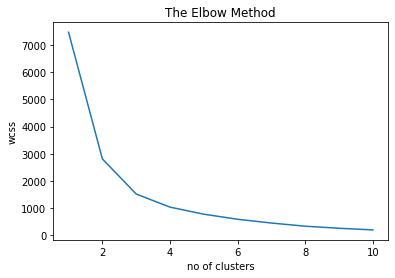

In [0]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
X = table.iloc[:,[3,4,5,6,7,8,9,10],].values
score = []

for cluster in range(1,11):
    kmeans = KMeans(n_clusters = cluster, init="k-means++", random_state=10)
    kmeans.fit(X)
    score.append(kmeans.inertia_)
plt.plot(range(1,11), score)
plt.title('The Elbow Method')
plt.xlabel('no of clusters')
plt.ylabel('wcss')
plt.show()

##9. Building K-Means model using sklearn library.


In [0]:
y = KMeans(n_clusters=3).fit_predict(X)
print(y)

[2 0 0 0 0 1 1 1 0 2 2 0 0 2 1 1 1 0 0 0 2 2 2 0]


##10. Plotting the K-Means cluster using Matplotlib library. It is suprising to see the direct positive correlation of PM10 and PM2.5 AQ index value.  

No handles with labels found to put in legend.


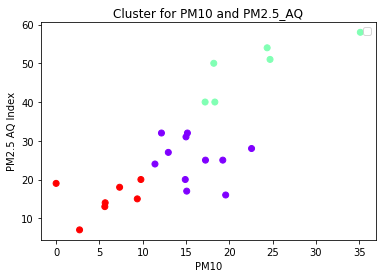

In [0]:
plt.scatter(X[:,3],X[:,6], c=y, cmap='rainbow')
plt.title('K-means Cluster for PM10 and PM2.5_AQ')
plt.xlabel('PM10')
plt.ylabel('PM2.5 AQ Index')
plt.legend()
plt.show()

##11. We know that there is a linear relationship between the pm10 mean value and pm10 AQ Index from AQI formula. But this will give an idea of overlap of points in GMM Clustter

No handles with labels found to put in legend.


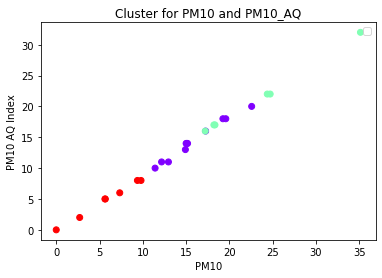

In [0]:
plt.scatter(X[:,3],X[:,7], c=y, cmap='rainbow')
plt.title('K-Means Cluster for PM10 and PM10_AQ')
plt.xlabel('PM10')
plt.ylabel('PM10 AQ Index')
plt.legend()
plt.show()

No handles with labels found to put in legend.


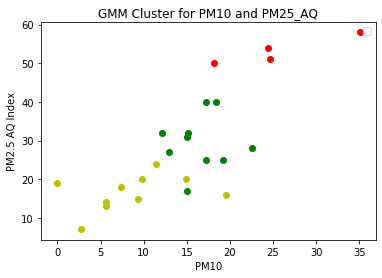

In [0]:
from sklearn.mixture import GaussianMixture 
X = table.iloc[:,[3,4,5,6,7,8,9,10]].values
d = pd.DataFrame(X)  
gmm = GaussianMixture(n_components = 3)
gmm.fit(d) 

labels = gmm.predict(d) 
d['labels'] = labels
d0 = d[d['labels']== 0] 
d1 = d[d['labels']== 1] 
d2 = d[d['labels']== 2] 
  

plt.scatter(d0[3], d0[6], c ='r') 
plt.scatter(d1[3], d1[6], c ='y') 
plt.scatter(d2[3], d2[6], c ='g') 
plt.title('GMM Cluster for PM10 and PM25_AQ')
plt.xlabel('PM10')
plt.ylabel('PM2.5 AQ Index')
plt.legend()
plt.show()

##12. We can clearly see that there are overalp of points in cluster.

No handles with labels found to put in legend.


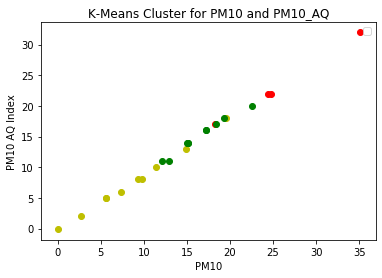

In [0]:
plt.scatter(d0[3], d0[7], c ='r') 
plt.scatter(d1[3], d1[7], c ='y') 
plt.scatter(d2[3], d2[7], c ='g') 
plt.title('K-Means Cluster for PM10 and PM10_AQ')
plt.xlabel('PM10')
plt.ylabel('PM10 AQ Index')
plt.legend()
plt.show()